# Using bpnet-lite to train a CTCF profile model
This notebook uses full-on bpnet-lite code (https://github.com/jmschrei/bpnet-lite/tree/master) from the BRR man himself. We use example data from an ENCODE CTCF ChIP-seq dataset and follow the basepairmodels repo for preprocessing it (https://github.com/kundajelab/basepairmodels/tree/master). We use the BPNet model from bpnet-lite to train a base-pair resolution model in the BPNet style. 

In [1]:
# Imports
import os
import torch
from pathlib import Path
from bpnetlite.io import extract_loci
from bpnetlite.io import PeakGenerator
from bpnetlite import BPNet

# Define paths
data_dir = Path("/cellar/shared/carterlab/data/ml4gland/ENCSR000EGM/data")
reference_dir = "/cellar/users/aklie/data/eugene/avsec21/reference"
peaks = os.path.join(data_dir, "peaks.bed")
seqs = "/cellar/users/aklie/data/ml4gland/use_cases/avsec21/reference/hg38.fa"
signals = [os.path.join(data_dir, "plus.bw"), os.path.join(data_dir, "minus.bw")]
controls = [os.path.join(data_dir, "control_plus.bw"), os.path.join(data_dir, "control_minus.bw")]

# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

# Load data

In [2]:
# Create a dataloader for the training peaks, this takes about just under 4 minutes to complete
training_data = PeakGenerator(peaks, seqs, signals, controls, chroms=training_chroms)
len(training_data)

In [3]:
# Check the shapes of the first batch
batch = next(iter(training_data))
batch[0].shape, batch[1].shape, batch[2].shape

(torch.Size([32, 4, 2114]),
 torch.Size([32, 2, 2114]),
 torch.Size([32, 2, 1000]))

In [4]:
# Grab the validation data, no jittering, augmenting, or shuffling, takes about 30 seconds
X_valid, y_valid, X_ctl_valid = extract_loci(peaks, seqs, signals, controls, chroms=valid_chroms, max_jitter=0)
X_valid.shape, y_valid.shape, X_ctl_valid.shape

(torch.Size([7051, 4, 2114]),
 torch.Size([7051, 2, 1000]),
 torch.Size([7051, 2, 2114]))

# Train a model

In [17]:
# Create the model, we need 2 channels for the control tracks, 2 channels for the signal tracks, and to trim to 1000 bp of input
model = BPNet(n_outputs=2, n_control_tracks=2, trimming=(2114 - 1000) // 2, name="bpnet.full")

In [18]:
# Test out a prediction batch
batch = next(iter(training_data))
pred_ctl = model.forward(*batch[:2])
pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([32, 2, 1000]), torch.Size([32, 1]))

In [19]:
# Send the model to the GPU
model.cuda()

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

In [20]:
# Quickly define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# Use the models fit_generator method to train the model
res = model.fit(
    training_data, 
    optimizer, 
    X_valid=X_valid, 
	X_ctl_valid=X_ctl_valid, 
    y_valid=y_valid,
    max_epochs=50,
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	0	32.4778	2.0698	665.6591	23.7246	804.9495	-5.514783e-05	-0.34265643	11.6427	True
0	100	4.0414	1.2553	500.2979	2.162	339.9838	0.09419764	-0.121059135	1.7242	True
0	200	3.211	1.2579	484.2079	0.849	317.3411	0.21790473	-0.105026774	0.7457	True
0	300	3.2213	1.2579	409.5439	0.7633	294.1711	0.31406042	-0.13523905	0.7104	True
0	400	3.2217	1.2582	472.8946	0.5812	283.4089	0.35545102	-0.11344804	0.9274	True
0	500	3.2248	1.2612	406.2135	0.7416	278.8667	0.37000778	-0.06426084	0.7528	True
0	600	3.2349	1.2612	392.2781	0.5167	275.799	0.38388687	-0.040320158	0.7922	True
0	700	3.2495	1.2609	446.1458	0.9227	274.3475	0.38948867	-0.0021190112	1.2293	True
0	800	3.2247	1.2616	374.293	0.6479	273.7456	0.39026368	0.06751235	0.7491	True
0	900	3.2543	1.2616	391.2222	0.4926	272.5157	0.3954194	0.15488341	0.6642	True
0	1000	3.2246	1.2612	439

# Generate a training curve and pull the stats for the best model

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [4]:
bpnetlite_log = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/full/bpnet.full.log", sep="\t")

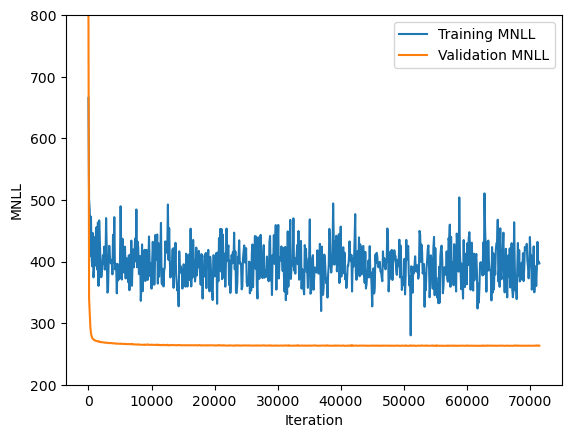

In [21]:
# Plot "MNLL" over "Iteration"
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Training MNLL"], label="Training MNLL")
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Validation MNLL"], label="Validation MNLL")
plt.xlabel("Iteration")
plt.ylabel("MNLL")
plt.ylim(200, 800)
plt.legend()
plt.savefig("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/bpnet/full_mnll.pdf", bbox_inches="tight", dpi=300)

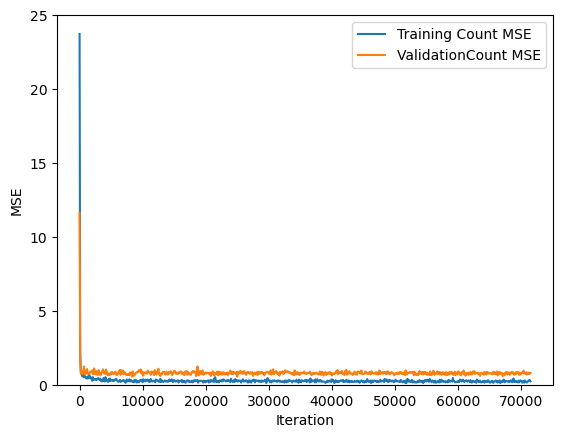

In [25]:
# Plot "MSE" over "Iteration"
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Training Count MSE"], label="Training Count MSE")
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Validation Count MSE"], label="ValidationCount MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.ylim(0, 25)
plt.legend()
plt.savefig("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/bpnet/full_mse.pdf", bbox_inches="tight", dpi=300)

In [20]:
# Get the last row of where "Saved?" is True
bpnetlite_final_log = bpnetlite_log[bpnetlite_log["Saved?"] == True].iloc[-1]
bpnetlite_final_log["type"] = "bpnetlite"
bpnetlite_final_log.to_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/full/bpnet.full.log.final", sep="\t", index=True, header=False)

# Scratch
